# BWR Whole Core Problem

This notebook discusses the application of tensor train (TT)-decomposition to the time-independent neutron transport (NTE) equation for a BWR whole core problem following the methedology presented in [Truong et al.](https://www.sciencedirect.com/science/article/pii/S002199912400192X) with added functionality. This added functionalty includes high-order scattering, reflective boundary conditions, and multi-region problems conforming to a regular rectangular grid. The following uses the multigroup and discrete ordiantes approximation with diamond difference. All calculations were done on a 16-core AMD Ryzen Threadripper PRO 5955WX.

The BWR whole core problem is given in the diagram and 2-group region cross sections (in $cm^{-1}$) shown below. The top and right boundaries are reflective and the bottom and left are vacuum. Each square region is given by the mesh grid of $\Delta\in\{30, 20, 20, 20, 20, 20, 20, 20, 10\}~cm$. These square regions were spatially discretized to produce a roughly uniform (by number of corner nodes) regular rectangular grid of corner nodes of shape $I\times J$ where $I=J=128$.

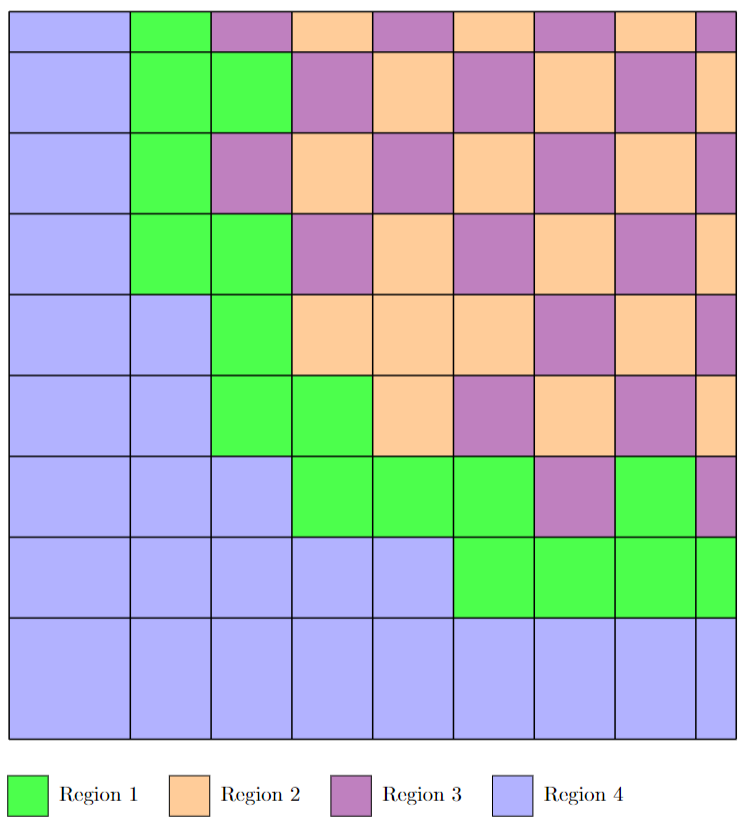

| Region | $g$ | $\Sigma_{t, g}$ | $\Sigma_{f, g}$ | $\Sigma_{s0, 1\rightarrow g}$ | $\Sigma_{s0, 2\rightarrow g}$ | $\Sigma_{s1, 1\rightarrow g}$ | $\Sigma_{s1, 2\rightarrow g}$| 
| -- |  -- |  -- |  -- |  -- | -- | -- | -- |
| 1 | 1 | 7.98455e-01 | 1.70856e-03 | 7.55018e-01 | 0.00000e+00 | 2.23455e-01 | 0.00000e+00 |
| 1 | 2 | 1.77753e+00 | 8.44429e-02 | 3.65559e-02 | 1.70841e+00 | 5.95095e-03 | 0.00000e+00 | 
| 2 | 1 | 7.98659e-01 | 1.39852e-03 | 7.55255e-01 | 0.00000e+00 | 2.23558e-01 | 0.00000e+00 | 
| 2 | 2 | 1.78706e+00 | 7.19738e-02 | 3.66907e-02 | 1.72841e+00 | 5.98157e-03 | 0.00000e+00 | 
| 3 | 1 | 8.00573e-01 | 1.02466e-03 | 7.56781e-01 | 0.00000e+00 | 2.21844e-01 | 0.00000e+00 |
| 3 | 2 | 1.79752e+00 | 5.44386e-02 | 3.72657e-02 | 1.74923e+00 | 5.99448e-03 | 0.00000e+00 |
| 4 | 1 | 8.67726e-01 | 0.00000e+00 | 8.22799e-01 | 0.00000e+00 | 3.79751e-01 | 0.00000e+00 |
| 4 | 2 | 2.04100e+00 | 0.00000e+00 | 4.45272e-02 | 2.02235e+00 | 1.78819e-02 | 0.00000e+00 |

In [1]:
%load_ext autoreload
%autoreload 2

import time
import itertools

import numpy as np
import matplotlib.pyplot as plt

from tt_nte.benchmarks import bwr_core
from tt_nte.methods import DiscreteOrdinates
from tt_nte.solvers import ALS, AMEn

The TT construction of the operaters within the NTE matches that shown in [Truong et al.](https://www.sciencedirect.com/science/article/pii/S002199912400192X); however, to accomodate multi-region problems, we apply a spatial indicator (1 where the region exists and 0 elsewhere) along the outgoing dimension of each spatial core. Therefore, there will be $2^S$, where $S$ is the number of spatial dimensions, additional ranks to each TT operator for each spatial region. This accomodates the piecewise constant cross sections varying betweeen material regions. As an example, suppose $I=J=10$ corresponding to the coarse discretization shown above. If we consider the bottom row all corresponding to the Region 4 cross sections, the total interaction operator for that portion of the problem is
$$
\mathcal{H}_{\Sigma}^{TT, 1} = \text{diag}(\Sigma_t)\circ(\boldsymbol{C}_1 \otimes \boldsymbol{I}_{L/4}) \circ \text{diag}(\boldsymbol{1}_y^1)\boldsymbol{Ip}_y^{+} \circ \text{diag}(\boldsymbol{1}_x^1) \boldsymbol{Ip}_x^{+},
$$
where 
$$
\begin{aligned}
\boldsymbol{1}^1_y &= \begin{bmatrix}
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix},\\
\boldsymbol{1}^1_x &= \begin{bmatrix}
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1
\end{bmatrix},
\end{aligned}
$$
and boundary condition 1 is ($\mu > 0, \eta > 0$). Notice the spatial indicator also depends on the boundary condition based on forward or backward differencing for that axis. Additionally, $\mathcal{H}_{\Sigma}^{TT}$ does not accomodate a non-zero boundary condition. Here the first element of $\boldsymbol{1}^1_y$ and $\boldsymbol{1}^1_x$ are zero. All boundary information is stored within $\mathcal{H}_x^{TT}, \mathcal{H}_y^{TT}, \mathcal{H}_z^{TT}$ where the meshing is not dependent on the material regions.

With this in mind, we continue with the BWR whole core problem. Below we initialize the cross section object and geometry with a $128\times128$ grid. We then initialize the discrete ordinates, `SN`, object in TT format (not QTT) with 4 total ordinates according to a square quadrature. The `regions` object defines the splitting of the BWR core into TT regions such that each region shown (numbered) in the figure below is its own TT that is summed into the overall operators. The `SN` object builds all the operators associated with the NTE. The order and core shapes of the TT operators are shown in the ouput below.

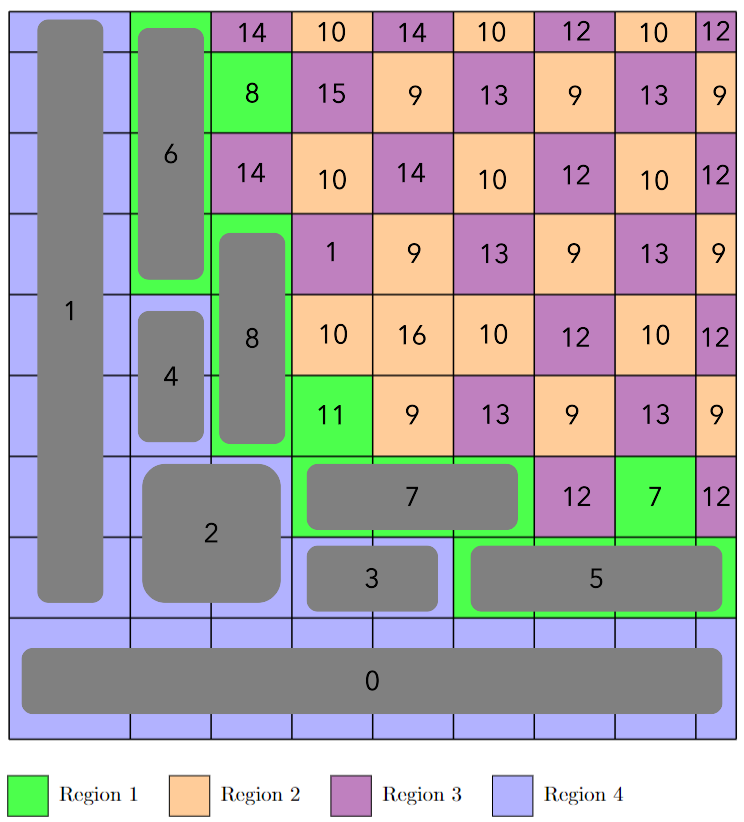

In [2]:
# Load unreflected data
xs_server, geometry, _, regions = bwr_core(128, reflected=False)

# Initialize SN solver
start = time.time()
SN = DiscreteOrdinates(
    xs_server=xs_server,
    geometry=geometry,
    num_ordinates=16,
    tt_fmt="tt",
    regions=regions,
)
print(f"H = {SN.H}")
print(f"F = {SN.F}")
print(f"S = {SN.S}")
unref_setup = time.time() - start
print(f"Setup time = {unref_setup}")

H = 
Tensor train with order    = 4, 
                  row_dims = [2, 16, 128, 128], 
                  col_dims = [2, 16, 128, 128], 
                  ranks    = [1, 2, 20, 18, 1]
F = 
Tensor train with order    = 4, 
                  row_dims = [2, 16, 128, 128], 
                  col_dims = [2, 16, 128, 128], 
                  ranks    = [1, 2, 8, 12, 1]
S = 
Tensor train with order    = 4, 
                  row_dims = [2, 16, 128, 128], 
                  col_dims = [2, 16, 128, 128], 
                  ranks    = [1, 3, 16, 14, 1]
Setup time = 6.445152282714844


With the operators built, we apply a similar TT-optimization strategy with power iteration to solve the $k$-eigenvalue NTE as was used in [Truong et al.](https://www.sciencedirect.com/science/article/pii/S002199912400192X) We first converge the solution to an error of 0.05 with [Alternating Linear Scheme (ALS)](https://epubs.siam.org/doi/10.1137/100818893) as the linear solver. Then the remaining iterations are done with the [Alternating Minimal Energy Method (AMEn)](https://epubs.siam.org/doi/abs/10.1137/140953289) to below a tolerance of 1e-5. The AMEn solver is configured to converge to a tolerance of 1e-6 with a maximum of 20 sweeps and a kickrank of 4.

In [3]:
# AMEn preconditioner (ALS solver)
start = time.time()
solver = ALS(method=SN, verbose=True)
solver.power(ranks=8, tol=5e-2, max_iter=250)
k0 = solver.k
psi0 = solver.psi
psi0.ortho(1e-8)
print(psi0)

# AMEn solver
solver = AMEn(method=SN, verbose=True)
solver.power(
    tol=1e-5,
    max_iter=1000,
    amen_nswp=30,
    amen_tol=1e-6,
    amen_kickrank=4,
    k0=k0,
    psi0=psi0,
)
unref_k = solver.k
unref_solve = time.time() - start
print(f"Total solution time = {unref_solve}")

-- ALS Power Iteration
--   Iteration = 1, k = 1.01191, psi error = 1.877626510876356
--   Iteration = 2, k = 1.02058, psi error = 0.06737521309202352
--   Iteration = 3, k = 1.02264, psi error = 0.03855011878107459
-- Converged: k = 1.02263627

Tensor train with order    = 4, 
                  row_dims = [2, 16, 128, 128], 
                  col_dims = [1, 1, 1, 1], 
                  ranks    = [1, 2, 8, 8, 1]
-- AMEn Power Iteration
amen_solve: swp=1, max_dx= 1.864E-02, max_res= 1.462E-01, max_rank=12
amen_solve: swp=2, max_dx= 1.679E-02, max_res= 9.685E-02, max_rank=16
amen_solve: swp=3, max_dx= 5.965E-03, max_res= 5.888E-02, max_rank=20
amen_solve: swp=4, max_dx= 3.226E-03, max_res= 3.658E-02, max_rank=24
amen_solve: swp=5, max_dx= 2.660E-03, max_res= 3.615E-02, max_rank=28
amen_solve: swp=6, max_dx= 1.449E-03, max_res= 2.106E-02, max_rank=32
amen_solve: swp=7, max_dx= 9.045E-04, max_res= 1.409E-02, max_rank=36
amen_solve: swp=8, max_dx= 6.252E-04, max_res= 9.744E-03, max_rank=40

To calculate the scalar flux we apply an integration operator, $Int_{N}^{TT}$, to $\mathcal{\psi}^{TT}$ using a matrix-by-vector product in TT format. The integral over the angular component is defined as
$$
Int_{N}^{TT} = \boldsymbol{Ig}\circ(\boldsymbol{1}_4^T \otimes \boldsymbol{w})\circ\boldsymbol{Iy}\circ\boldsymbol{Ix}
$$
where $\boldsymbol{1}_4 = \begin{bmatrix}1 & 1 & 1 & 1\end{bmatrix}$, $\boldsymbol{w}$ is a vector of the ordinate weights, and $\boldsymbol{Iy}$ and $\boldsymbol{Ix}$ are identity matrices for the $x$ and $y$ axes, respectively.

Angular Flux TT 
Tensor train with order    = 4, 
                  row_dims = [2, 16, 128, 128], 
                  col_dims = [1, 1, 1, 1], 
                  ranks    = [1, 2, 32, 132, 1]
Scalar Flux TT 
Tensor train with order    = 4, 
                  row_dims = [2, 1, 128, 128], 
                  col_dims = [1, 1, 1, 1], 
                  ranks    = [1, 2, 2, 128, 1]


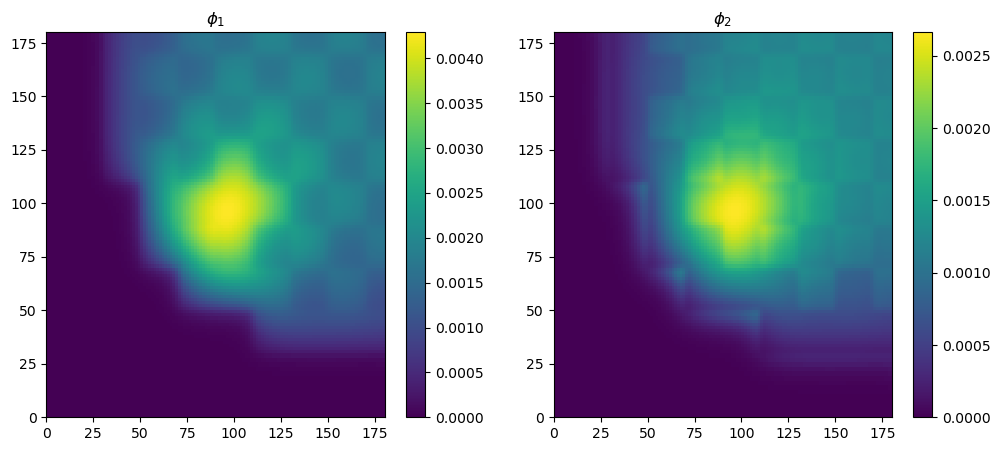

In [8]:
# Apply directional integration TT
phi = SN.Int_N @ solver.psi
print(f"Angular Flux TT {solver.psi}")
print(f"Scalar Flux TT {phi}")

# Index energy core to get specific group
xy_num_nodes = geometry.dx.size + 1
phi_0 = SN.get_group(phi, 0).matricize().reshape((xy_num_nodes, xy_num_nodes))
phi_1 = SN.get_group(phi, 1).matricize().reshape((xy_num_nodes, xy_num_nodes))

# Apply diamond difference to get cell-centered values
phi_0 = 1 / 4 * (phi_0[:-1, :-1] + phi_0[1:, :-1] + phi_0[1:, 1:] + phi_0[:-1, 1:])
phi_1 = 1 / 4 * (phi_1[:-1, :-1] + phi_1[1:, :-1] + phi_1[1:, 1:] + phi_1[:-1, 1:])

# Plot scalar flux solution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
X = np.array(list(itertools.accumulate([0] + geometry.dx.flatten().tolist())))
Y = np.array(list(itertools.accumulate([0] + geometry.dy.flatten().tolist())))
c = ax1.pcolormesh(X, Y, phi_0)
fig.colorbar(c)
ax1.set_title("$\\phi_1$")
c = ax2.pcolormesh(X, Y, phi_1)
fig.colorbar(c)
ax2.set_title("$\\phi_2$")
plt.show()